In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from utils import *

In [13]:
def fd_A_neu(n, neus=['left', 'right'], diris=['top', 'bottom']):
    '''
    Generate linear system for 
        Top, Down Dirichlet Left, Right Neumann Boundary
    '''
    N2 = n**2
    A = sparse.lil_matrix((N2, N2))
    
    for i in range(1, n-1):
        for j in range(1, n-1):
            idx = i * n + j
            A[idx, idx] += 4
            A[idx, idx-1] = -1
            A[idx, idx+1] = -1
            A[idx, idx-n] = -1
            A[idx, idx+n] = -1
    
    # Neumann Boundary
    for k in neus:
        if k == 'top':
            for i in range(1, n-1):
                idx = 0 * n + i
                A[idx, idx] = 4
                A[idx, idx+n] = -2
                A[idx, idx-1] = A[idx, idx+1] = -1
                
        if k == 'bottom':
            for i in range(1, n-1):
                idx = (n-1) * n + i
                A[idx, idx] = 4
                A[idx, idx-n] = -2
                A[idx, idx-1] = A[idx, idx+1] = -1
                
        if k == 'left':
            for i in range(1, n-1):
                idx = i * n
                A[idx, idx] = 4
                A[idx, idx+1] = -2
                A[idx, idx-n] = A[idx, idx+n] = -1
                
        if k == 'right':
            for i in range(1, n-1):
                idx = i * n + n -1
                A[idx, idx] = 4
                A[idx, idx-1] = -2
                A[idx, idx-n] = A[idx, idx+n] = -1
                
    # Dirichlet Boundary
    for k in diris:
        if k == 'top':
            for i in range(0, n):
                idx = 0 * n + i
                A[idx, idx] = 1
                
        if k == 'bottom':
            for i in range(0, n):
                idx = (n-1) * n + i
                A[idx, idx] = 1
                
        if k == 'left':
            for i in range(0, n):
                idx = i * n
                A[idx, idx] = 1
            
        if k == 'right':
            for i in range(0, n):
                idx = i * n + n -1
                A[idx, idx] = 1
    A = A.tocoo()
    return A

def apply_neumann_bc(b, h, f, bcs={'left': 0, 'right': 0}):
    '''
    Apply Neumann boundary conditions on the left, right boundary.
    '''
    n = int(np.sqrt(len(b)))
    h2 = h**2
    for k in bcs.keys():
        g = bcs[k]
        if k == 'top':
            for i in range(1, n-1):
                idx = i
                b[idx] = h2 * f[0, i] - 2 * h * g

        if k == 'bottom':
            for i in range(1, n-1):
                idx = (n-1) * n + i
                b[idx] = h2 * f[-1, i] - 2 * h * g
        
        if k == 'left':
            for i in range(1, n-1):
                idx = i * n
                b[idx] = h2 * f[i, 0] - 2 * h * g

        if k == 'right':
            for i in range(1, n-1):
                idx = i * n + n - 1
                b[idx] = h2 * f[i, -1] - 2 * h * g
        
    return b

def apply_diri_bc(b, bcs={'top': 0, 'bottom': 0}):
    n = int(np.sqrt(len(b)))
    
    for k in bcs.keys():
        g = bcs[k]
        if k == 'top':
            for i in range(n):
                idx = 0 * n + i
                b[idx] = g
        if k == 'bottom':
            for i in range(n):
                idx = (n-1) * n + i
                b[idx] = g
        if k == 'left':
            for i in range(n):
                idx = i * n
                b[idx] = g
        if k == 'right':
            for i in range(n):
                idx = i * n + n - 1 
                b[idx] = g
    return b

In [14]:
n = 129
h = 2/(n-1)
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
xx, yy = np.meshgrid(x, y)
f = -normal(xx, yy, h)

A_bc = fd_A_with_bc(n).tocsr()
b_bc = fd_b_bc(f, h)
b_bc = apply_dirichlet_bc(b_bc, True, 1)
u_bc = spsolve(A_bc, b_bc).reshape(n, n)

A = fd_A_neu(n, neus=['top', 'bottom'], diris=['left', 'right']).tocsr()
b = fd_b_bc(f, h)
b = apply_neumann_bc(b, h, f, bcs={'top':1, 'bottom':1})
b = apply_diri_bc(b, bcs={'left': 1, 'right': 1})
u = spsolve(A, b).reshape(n, n)


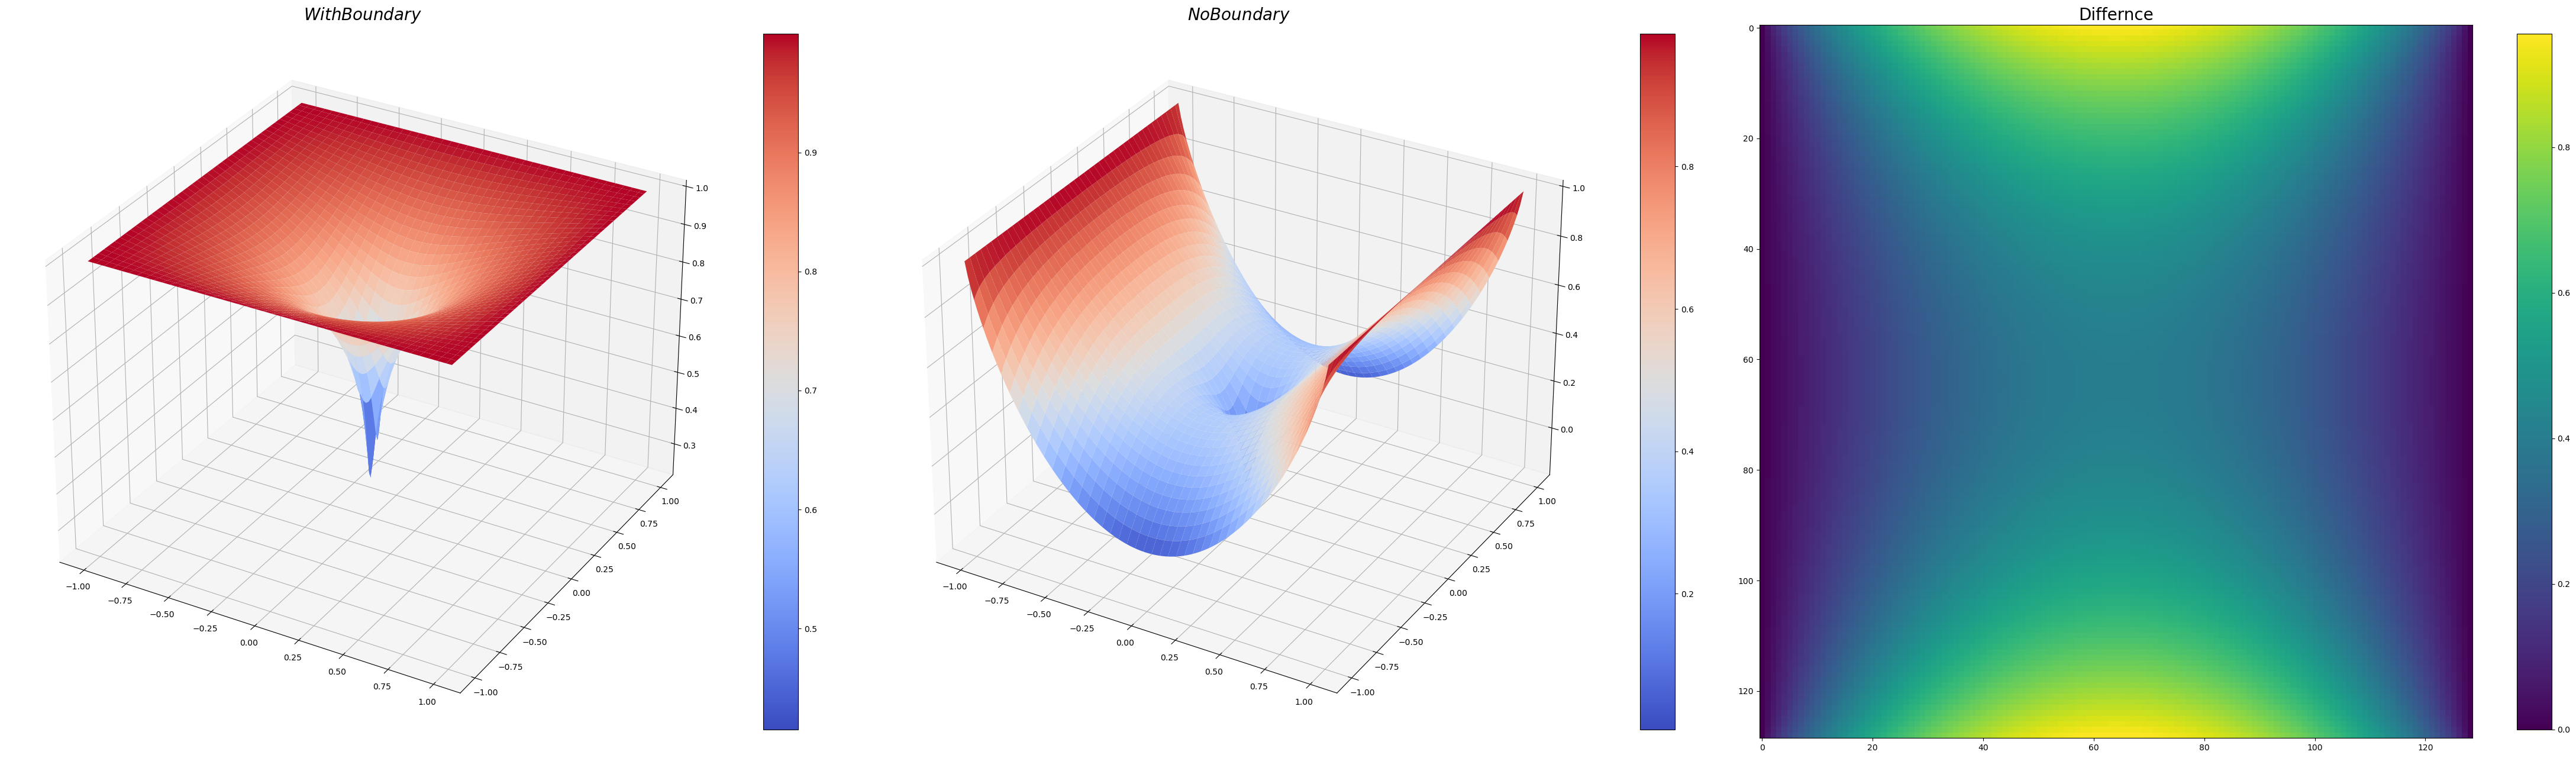

In [15]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(45)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3)

ax1.set_title(f'$With Boundary$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, u_bc, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$No Boundary$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(np.abs(u_bc - u))
plt.colorbar(im, shrink=0.8, ax=ax3)

fig.tight_layout()

In [ ]:
def jacobi_2nd(A, b, tolerance=1e-10, max_iterations=1000):

    x = np.zeros_like(b, dtype=np.double)
    
    T = (A - sparse.diags(A.diagonal()))/ 4
    
    for k in range(max_iterations):
        
        x_old  = x.copy()
        
        x[:] = (b - T.dot(x)) / 4
        
#         diff = np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) 
        diff = np.linalg.norm(x - x_old, ord=np.inf)

        print(f'{diff:.3e}')
        if diff < tolerance:
            break
    return x